In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
import random
import time
from tensorflow.keras.layers import Dense, Flatten, Conv2D,MaxPooling2D,Dropout
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.applications import MobileNetV3Large
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, accuracy_score
from matplotlib.colors import LinearSegmentedColormap
import os
import cv2
import math
from imblearn.over_sampling import RandomOverSampler

In [2]:
directory='./Belgium_Datasets'
train_dir=directory+'/BelgiumTSC_Training/Training'
test_dir=directory+'/BelgiumTSC_Testing/Testing'
trainclasses=os.listdir(train_dir)
testclasses=os.listdir(test_dir)

In [3]:
print(trainclasses)

['00030', '00052', '00002', '00058', '00046', '00057', '00034', '00055', '00050', '00029', '00009', '00036', '00019', '00047', '00018', '00017', '00059', '00016', '00023', '00020', '00045', '00025', '00041', '00005', '00006', '00060', '00014', '00043', '00007', '00053', '00008', '00051', '00010', '00038', '00013', '00035', '00024', '00015', '00042', '00056', '00033', '00061', '00000', '00049', '00022', '00011', '00054', '00039', '00048', '00001', '00044', '00031', '00027', '00003', '00021', '00004', '00037', '00040', '00012', '00026', '00028', '00032']


In [4]:
df=[[]]
df=pd.DataFrame(df)
for i in trainclasses:
    path = "./Belgium_Datasets/BelgiumTSC_Training/Training/"+i+"/GT-"+i+".csv"
    df1 = pd.read_csv(path,sep=';')
    df1['Filename']="./Belgium_Datasets/BelgiumTSC_Training/Training/"+i+'/'+df1["Filename"]
    df=pd.concat([df,df1],ignore_index=True)

df['Rotate']=0
df["length"] = df["Roi.X2"]-df["Roi.X1"]
df["height"] = df["Roi.Y2"]-df["Roi.Y1"]
df=df.dropna()
df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate,length,height
1,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,128.0,128.0,11.0,11.0,117.0,117.0,30.0,0,106.0,106.0
2,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,215.0,155.0,18.0,13.0,197.0,142.0,30.0,0,179.0,129.0
3,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,97.0,94.0,8.0,8.0,88.0,86.0,30.0,0,80.0,78.0
4,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,205.0,200.0,17.0,17.0,187.0,183.0,30.0,0,170.0,166.0
5,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,155.0,151.0,13.0,13.0,141.0,137.0,30.0,0,128.0,124.0


In [5]:
df.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate,length,height
count,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000,4591.0,4591.000000,4591.000000
mean,124.844261,109.740362,10.558048,9.348508,113.778697,99.883032,34.005228,0.0,103.220649,90.534524
std,73.056649,60.209324,5.982332,4.860009,67.072788,55.385101,16.067205,0.0,61.111287,50.557826
min,22.000000,20.000000,5.000000,5.000000,16.000000,14.000000,0.000000,0.0,11.000000,9.000000
25%,79.000000,69.000000,7.000000,6.000000,71.000000,63.000000,22.000000,0.0,64.000000,57.000000
50%,107.000000,96.000000,9.000000,8.000000,97.000000,88.000000,37.000000,0.0,88.000000,80.000000
75%,151.000000,133.500000,13.000000,11.000000,137.000000,122.000000,46.000000,0.0,124.000000,111.000000
max,724.000000,529.000000,60.000000,44.000000,664.000000,484.000000,61.000000,0.0,604.000000,440.000000


In [6]:
num_of_classes = df["ClassId"].nunique()
resize_x  = 32
resize_y  = 32
num_of_channels = 3
directory = ""
Epochs=200
train_length = len(df)
Y_col_name="ClassId"

In [7]:
# Necessary Functions
def remove_outlier(df,parameter):
    Percentile25 = df[parameter].quantile(0.25)
    Percentile75 = df[parameter].quantile(0.75)
    iqr = Percentile75 - Percentile25
    lowerlimit = Percentile25 - 1.5*iqr
    upperlimit = Percentile75 + 1.5*iqr
    temp1 = df[parameter]>lowerlimit
    temp2 = df[parameter]<upperlimit
    return df[temp1 & temp2] 

def get_max_index(arr):
    length = len(arr)
    mini = 0
    value = 0
    for i,val in enumerate(arr):
        if mini < val :
            mini = val
            value = i
    return value

def viewStatistics(df):
    #Statistics of Data
    print("Total Training Examples : ",len(df))
    values = df["ClassId"].value_counts()
    x_labels = [str(x) for x in range(num_of_classes)]
    y_labels = [0 for i in range(num_of_classes)]
    for x in values.keys():
        y_labels[int(x)]+=values[x]
    plt.figure(figsize=(15, 6))
    plt.bar(x_labels,y_labels,width=0.5)
    plt.title('Bar Graph')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

def Predict_for_single_example(model,img):
    img  = np.array(img)
    img  = tf.convert_to_tensor(img,dtype=float)
    img = img/255.0
    img = tf.expand_dims(img, axis=0)
    probability = model.predict(img)
    value = get_max_index(probability[0])
    return value
    
def Predict_for_Multiple_examples(model,images):
    img = []
    for j in range(len(images)):
        img.append(np.array(images[j]))
    img = np.array(img)
    img = tf.convert_to_tensor(img,dtype=float)
    img = img/255.0
    probability = model.predict(img)
    values = []
    for val in probability:
        values.append(get_max_index(val))
    return values

def PredictTest(model,df,start,length):
    images = []
    y_test = []
    length = min(length,len(df)-start)
    for i in range(length):
        row = df.loc[start+i].values
        images.append(Image.open(directory+row[7]).crop((row[2],row[3],row[4],row[5])).resize((resize_x,resize_y)))
        y_test.append(row[6])
    

    y_predicted = Predict_for_Multiple_examples(model,images)

    return y_test,y_predicted

def PredictTest(model,df):
    images = []
    y_test = []
    length = len(df)
    for i in range(length):
        row = df.loc[i].values
        images.append(Image.open(directory+row[7]).crop((row[2],row[3],row[4],row[5])).resize((resize_x,resize_y)))
        y_test.append(row[6])
        
    y_predicted = Predict_for_Multiple_examples(model,images)

    return y_test,y_predicted

Total Training Examples :  4591


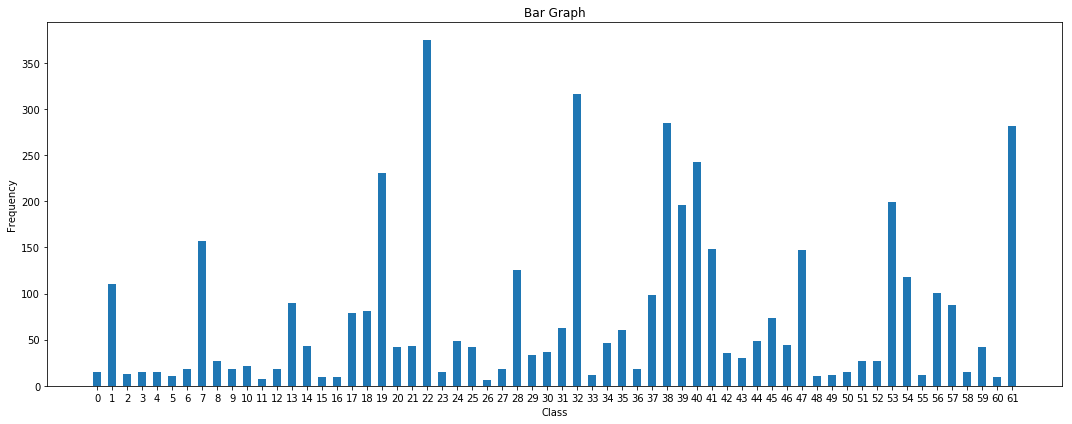

In [8]:
#Statistics of Data
viewStatistics(df)

In [9]:
train_length = len(df)
print("Total Training Examples : ",len(df))

Total Training Examples :  4591


Total Training Examples :  23250


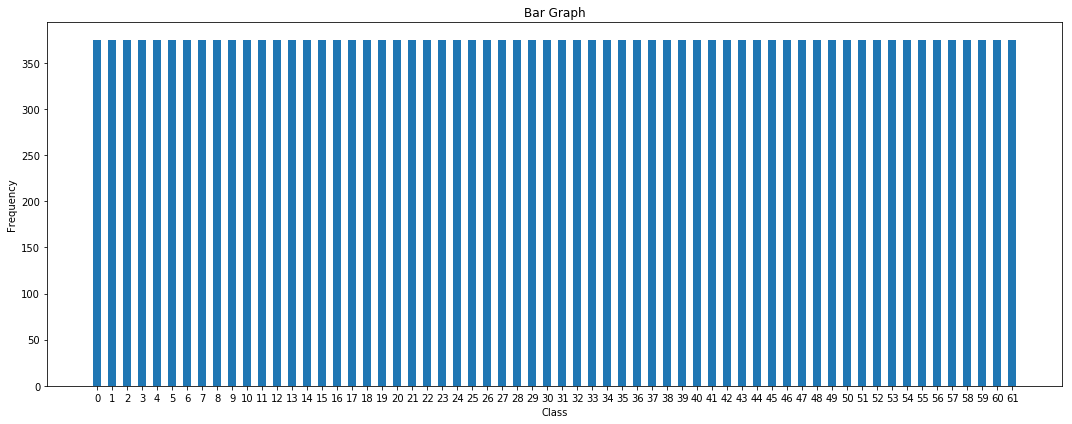

In [10]:
X = df.drop(Y_col_name, axis=1)
y = df[Y_col_name]
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Fit and apply the oversampler to the data
X_resampled, y_resampled = oversampler.fit_resample(X, y)

df = pd.DataFrame(X_resampled, columns=X.columns)
df[Y_col_name] = y_resampled
df[Y_col_name].astype(str)

viewStatistics(df)

In [11]:
df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,Rotate,length,height,ClassId
0,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,128.0,128.0,11.0,11.0,117.0,117.0,0,106.0,106.0,30.0
1,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,215.0,155.0,18.0,13.0,197.0,142.0,0,179.0,129.0,30.0
2,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,97.0,94.0,8.0,8.0,88.0,86.0,0,80.0,78.0,30.0
3,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,205.0,200.0,17.0,17.0,187.0,183.0,0,170.0,166.0,30.0
4,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,155.0,151.0,13.0,13.0,141.0,137.0,0,128.0,124.0,30.0


In [12]:
# Sample Images and there crop according to data given in csv
def showExamples(df):
    num_rows = 5
    num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 20))
    total_images = []
    for i in range(5):
        integer = random.randint(0,len(df))
        total_images.append(df.iloc[integer].values)
    total_images = list(total_images)
    for i,val in enumerate(total_images):
        row = i
        col=0
        ax = axes[row, col]
        img = Image.open(directory+val[0])
        ax.imshow(img)
        img = img.crop((val[3],val[4],val[5],val[6]))
        ax = axes[row,col+1]
        ax.imshow(img)
        ax.set_title(directory+val[0])
        print(directory+val[0])
    ax.axis('off')

def showTestExamples(df):
    num_rows = 5
    num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 20))
    total_images = []
    for i in range(5):
        integer = random.randint(0,len(df))
        total_images.append(df.iloc[integer].values)
    total_images = list(total_images)
    for i,val in enumerate(total_images):
        row = i
        col=0
        ax = axes[row, col]
        img = Image.open(directory+val[0])
        ax.imshow(img)
        img = img.crop((val[3],val[4],val[5],val[6]))
        ax = axes[row,col+1]
        ax.imshow(img)
        ax.set_title("Class : "+str(val[7]))
    ax.axis('off')
    

./Belgium_Datasets/BelgiumTSC_Training/Training/00046/00814_00000.ppm
./Belgium_Datasets/BelgiumTSC_Training/Training/00002/00270_00000.ppm
./Belgium_Datasets/BelgiumTSC_Training/Training/00020/01855_00001.ppm
./Belgium_Datasets/BelgiumTSC_Training/Training/00003/00259_00002.ppm
./Belgium_Datasets/BelgiumTSC_Training/Training/00037/01311_00002.ppm


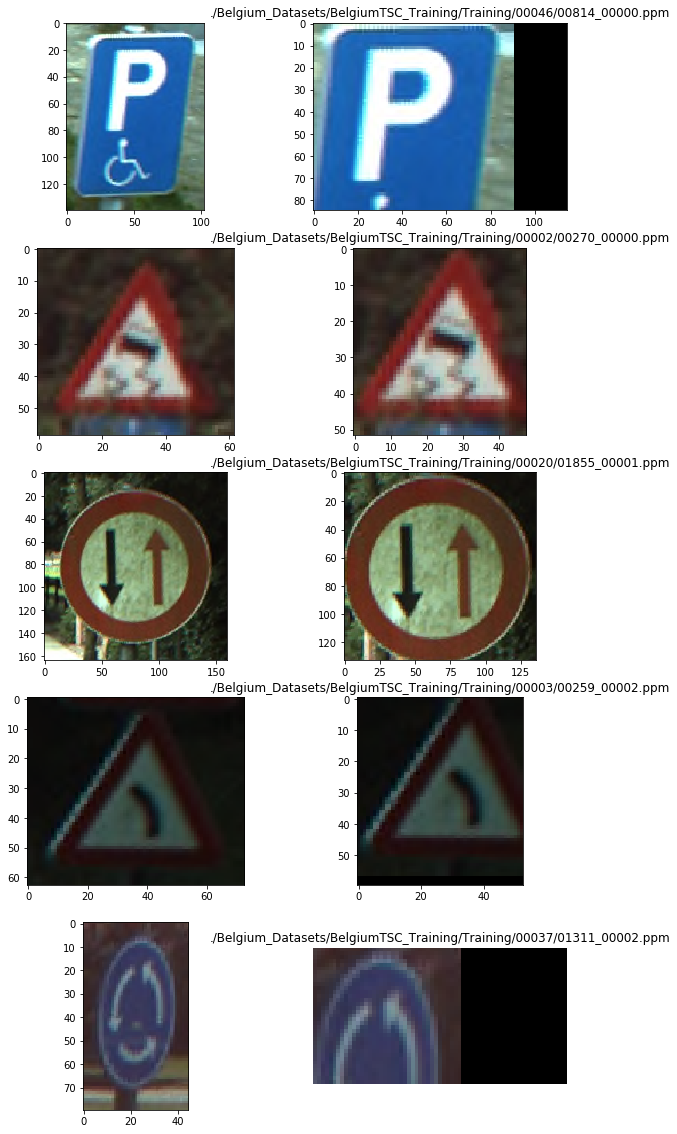

In [13]:
showExamples(df)

In [14]:
# Load pre-trained ResNet50 model with random weights
model = MobileNetV3Large(weights=None, input_shape=(resize_x, resize_y, 3), classes=num_of_classes)

# Display the model summary
model.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 32, 32, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 16, 16, 16)   432         rescaling[0][0]                  
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 16, 16, 16)   64          Conv[0][0]                       
___________________________________________________________________________________

In [15]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
print(df["ClassId"].dtype)
# df["ClassId"] = df["ClassId"].astype(int)
# print(df["ClassId"].dtype)

float64


In [17]:
df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,Rotate,length,height,ClassId
0,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,128.0,128.0,11.0,11.0,117.0,117.0,0,106.0,106.0,30.0
1,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,215.0,155.0,18.0,13.0,197.0,142.0,0,179.0,129.0,30.0
2,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,97.0,94.0,8.0,8.0,88.0,86.0,0,80.0,78.0,30.0
3,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,205.0,200.0,17.0,17.0,187.0,183.0,0,170.0,166.0,30.0
4,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,155.0,151.0,13.0,13.0,141.0,137.0,0,128.0,124.0,30.0


In [18]:
class Data:
    def __init__(self,df,size_x,size_y):
        self.df = df
        self.root = directory
        self.resize_x = size_x
        self.resize_y = size_y
    
    def resize_and_center(self,image, target_height, target_width):
        original_height, original_width= image.size
        height_ratio = target_height / original_height
        width_ratio = target_width / original_width
        resize_ratio = min(height_ratio, width_ratio)
        new_height = int(original_height * resize_ratio)
        new_width = int(original_width * resize_ratio)
        image  = np.array(image)
        resized_image = cv2.resize(image, (new_width, new_height))
        pad_height = max(0, (target_height - new_height) // 2)
        pad_width = max(0, (target_width - new_width) // 2)
        centered_image = cv2.copyMakeBorder(resized_image, pad_height, target_height - new_height - pad_height,pad_width, target_width - new_width - pad_width,cv2.BORDER_CONSTANT, value=(255, 255, 255))
        return centered_image

    def Do_Crop(self,path,x1,y1,x2,y2):
        img = Image.open(self.root+path)
        img = img.crop((x1,y1,x2,y2))
        img = img.resize((resize_x,resize_y))
        img = np.array(img,dtype=float)
        img = img/255.0
        return img
    
    def Row_Data(self,row):
        img = self.Do_Crop(row["Filename"],row["Roi.X1"],row["Roi.Y1"],row["Roi.X2"],row["Roi.Y2"])
        self.X.append(img)
        self.Y.append(int(float(row["ClassId"])))

        
    def Get_Data(self):
        self.X = []
        self.Y = []
        for i in range(len(self.df)):
            row = self.df.iloc[i]
            self.Row_Data(row)
        self.X = np.array(self.X)
        self.Y = np.array(self.Y,dtype=int)

In [19]:
def miniDataTrain(model,df,train_split):
    data = Data(df,resize_x,resize_y)
    data.Get_Data()
    X_train = data.X
    Y_train = []
    for val in data.Y:
        x = [0]*num_of_classes
        x[int(val)]=1
        x = np.array(x)
        Y_train.append(x)
    Y_train = np.array(Y_train)
#     for i,v in enumerate(X_train):
#         print(data.Y[i])
#         plt.imshow(v)
#         plt.show()
    history = model.fit(X_train,Y_train,epochs=1,batch_size=len(X_train),validation_split=1-train_split,verbose=0)
    training_accuracy = history.history['accuracy'][0]
    validation_accuracy = history.history['val_accuracy'][0]
    loss = history.history['loss'][0]
    val_loss = history.history['val_loss'][0]
    return [training_accuracy,validation_accuracy,loss,val_loss]

def SingleEpochTrain(model,df,batchsize=256,train_split=0.8):
    num_train = len(df)
    df = df.sample(frac=1)
    num_mini_trains = math.ceil(num_train/batchsize)
    training_accuracy = 0
    validation_accuracy = 0
    loss = 0
    val_loss = 0
    starting_time = time.time()
    for i in range(num_mini_trains):      
        if(num_mini_trains == i+1):
            presentBatchSize = num_train - i*batchsize
        else :
            presentBatchSize = batchsize      
        df1 = df.iloc[i*batchsize:i*batchsize+presentBatchSize,:]
        params = miniDataTrain(model,df1,train_split)
        training_accuracy += presentBatchSize*params[0]
        validation_accuracy+= presentBatchSize*params[1]
        loss += params[2]
        val_loss += params[3]
    training_accuracy/=(num_train)
    validation_accuracy/=(num_train)
    ending_time = time.time()
    total_time = ending_time - starting_time
    total_time/=60
    print("Accuracy: ",training_accuracy," Val Accuracy: ",validation_accuracy," Trained for ",total_time," min")
    return [training_accuracy,validation_accuracy,loss,val_loss];
    

In [20]:
start_time   = time.time()

training_accuracy = []
validation_accuracy = []
loss = []
val_loss = []

for i in range(Epochs):
    print("Epoch : ", i)
    params = SingleEpochTrain(model,df)
    training_accuracy.append(params[0])
    validation_accuracy.append(params[1])
    loss.append(params[2])
    val_loss.append(params[3])

end_time = time.time()
print("Time taken : ", (end_time - start_time)/60," min")

Epoch :  0
Accuracy:  0.6831752039796563  Val Accuracy:  0.015245658054146715  Trained for  1.0256746610005696  min
Epoch :  1
Accuracy:  0.8870893964152182  Val Accuracy:  0.017157982352279846  Trained for  0.8571404933929443  min
Epoch :  2
Accuracy:  0.919850724184385  Val Accuracy:  0.0169429285848333  Trained for  0.8671596964200338  min
Epoch :  3
Accuracy:  0.9339917741385839  Val Accuracy:  0.015675765609548937  Trained for  0.8270920912424723  min
Epoch :  4
Accuracy:  0.952450345629005  Val Accuracy:  0.015248966549192706  Trained for  0.8412333528200785  min
Epoch :  5
Accuracy:  0.960114479459742  Val Accuracy:  0.013763441311415806  Trained for  0.8502549091974895  min
Epoch :  6
Accuracy:  0.9630286700648646  Val Accuracy:  0.01736641898607054  Trained for  0.8652055899302165  min
Epoch :  7
Accuracy:  0.9655654611382433  Val Accuracy:  0.01673449188951523  Trained for  0.8661312460899353  min
Epoch :  8
Accuracy:  0.962111528770898  Val Accuracy:  0.014828784560964953  T

In [21]:
#Saving the model
model.save("mobileNetV3")

/raid/home/dgx1442/finalYearProject/venv/lib/python3.6/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: mobileNetV3/assets


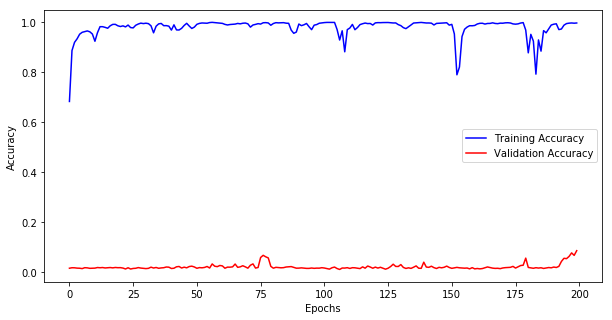

In [22]:
epochs  = [x for x in range(Epochs)]
plt.figure(figsize=(10,5))
plt.plot(epochs,training_accuracy,color="blue",label="Training Accuracy")
plt.plot(epochs,validation_accuracy,color="red",label="Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

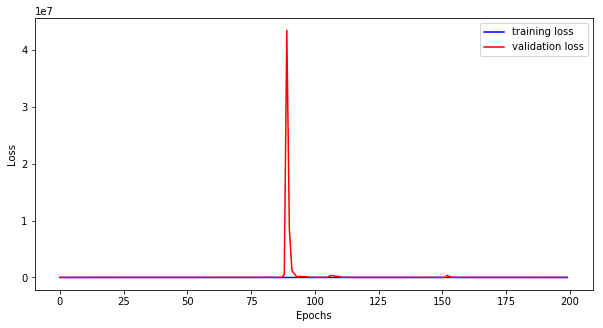

In [23]:
epochs  = [x for x in range(Epochs)]
plt.figure(figsize=(10,5))
plt.plot(epochs,loss,color="blue",label="training loss")
plt.plot(epochs,val_loss,color="red",label="validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [24]:
df_test=[[]]
df_test=pd.DataFrame(df_test)
for i in trainclasses:
    path = "./Belgium_Datasets/BelgiumTSC_Testing/Testing/"+i+"/GT-"+i+".csv"
    df1 = pd.read_csv(path,sep=';')
    df1['Filename']="./Belgium_Datasets/BelgiumTSC_Testing/Testing/"+i+'/'+df1["Filename"]
    df_test=pd.concat([df_test,df1],ignore_index=True)

df_test['Rotate']=0
df_test["length"] = df_test["Roi.X2"]-df_test["Roi.X1"]
df_test["height"] = df_test["Roi.Y2"]-df_test["Roi.Y1"]
df_test=df_test.dropna()
df_test.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate,length,height
1,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,108.0,106.0,9.0,9.0,99.0,97.0,30.0,0,90.0,88.0
2,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,52.0,53.0,5.0,5.0,46.0,47.0,30.0,0,41.0,42.0
3,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,70.0,68.0,6.0,6.0,63.0,62.0,30.0,0,57.0,56.0
4,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,75.0,67.0,6.0,6.0,68.0,61.0,30.0,0,62.0,55.0
5,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,74.0,73.0,6.0,6.0,67.0,67.0,30.0,0,61.0,61.0


In [25]:
df_test.tail()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate,length,height
2530,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,136.0,139.0,11.0,12.0,125.0,126.0,32.0,0,114.0,114.0
2531,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,291.0,133.0,24.0,11.0,266.0,122.0,32.0,0,242.0,111.0
2532,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,96.0,87.0,8.0,7.0,87.0,80.0,32.0,0,79.0,73.0
2533,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,84.0,81.0,7.0,7.0,76.0,73.0,32.0,0,69.0,66.0
2534,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,74.0,73.0,6.0,6.0,68.0,66.0,32.0,0,62.0,60.0


Total Training Examples :  2534


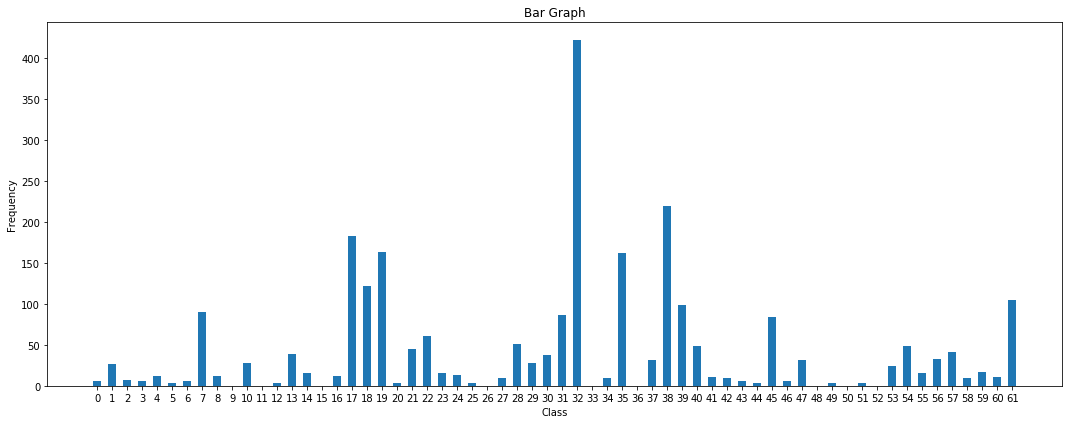

In [26]:
viewStatistics(df_test)

In [27]:
# showExamples(df_test)
df_test.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate,length,height
count,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.0,2534.000000,2534.000000
mean,105.959747,98.034333,9.069061,8.465667,96.378453,89.050513,31.206393,0.0,87.309392,80.584846
std,66.785123,57.725093,5.400023,4.588323,61.413788,53.160431,14.229258,0.0,56.044359,48.613323
min,26.000000,21.000000,5.000000,5.000000,21.000000,15.000000,0.000000,0.0,16.000000,10.000000
25%,60.250000,58.000000,5.000000,5.000000,55.000000,52.000000,19.000000,0.0,50.000000,47.000000
50%,86.000000,81.000000,7.000000,7.000000,78.000000,74.000000,32.000000,0.0,71.000000,67.000000
75%,131.000000,122.000000,11.000000,10.000000,120.000000,111.000000,38.000000,0.0,109.000000,101.000000
max,704.000000,500.000000,59.000000,42.000000,644.000000,458.000000,61.000000,0.0,585.000000,416.000000


Total Training Examples :  22366


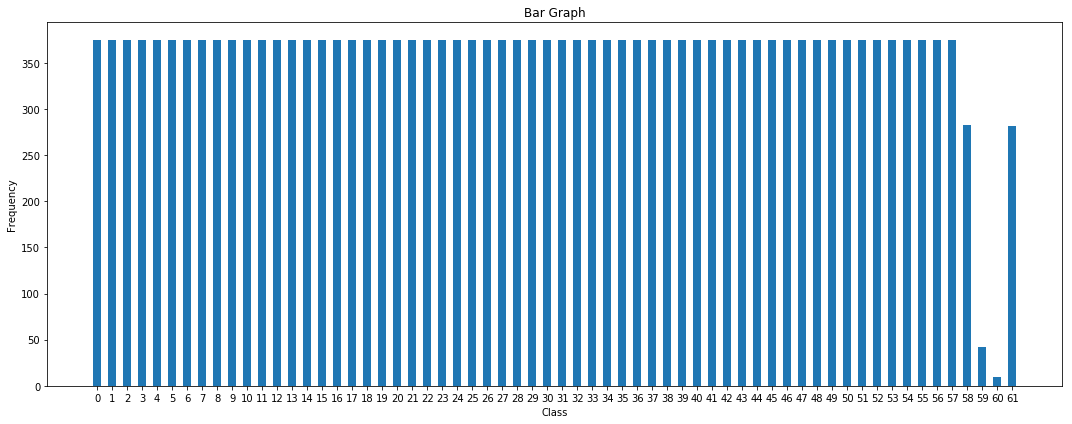

In [28]:
XTest = df_test.drop(Y_col_name, axis=1)
yTest = df_test[Y_col_name]
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Fit and apply the oversampler to the data
XTest_resampled, yTest_resampled = oversampler.fit_resample(XTest, yTest)

df_test = pd.DataFrame(XTest_resampled, columns=XTest.columns)
df_test[Y_col_name] = y_resampled
df_test[Y_col_name].astype(str)

viewStatistics(df_test)

In [29]:
# showExamples(df_test)
df_test.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,Rotate,length,height,ClassId
count,22366.000000,22366.000000,22366.000000,22366.000000,22366.000000,22366.000000,22366.0,22366.000000,22366.000000,22366.000000
mean,106.483457,97.457480,9.032058,8.372306,96.943128,88.555307,0.0,87.911070,80.183001,29.352991
std,62.551032,53.628465,5.111666,4.291267,57.459997,49.380742,0.0,52.369474,45.122318,17.271142
min,26.000000,21.000000,5.000000,5.000000,21.000000,15.000000,0.0,16.000000,10.000000,0.000000
25%,67.000000,59.000000,6.000000,5.000000,60.000000,53.000000,0.0,54.000000,48.000000,14.000000
50%,87.000000,81.000000,7.000000,7.000000,79.000000,74.000000,0.0,72.000000,67.000000,29.000000
75%,131.000000,121.000000,11.000000,10.000000,119.000000,110.000000,0.0,108.000000,100.000000,44.000000
max,704.000000,500.000000,59.000000,42.000000,644.000000,458.000000,0.0,585.000000,416.000000,61.000000


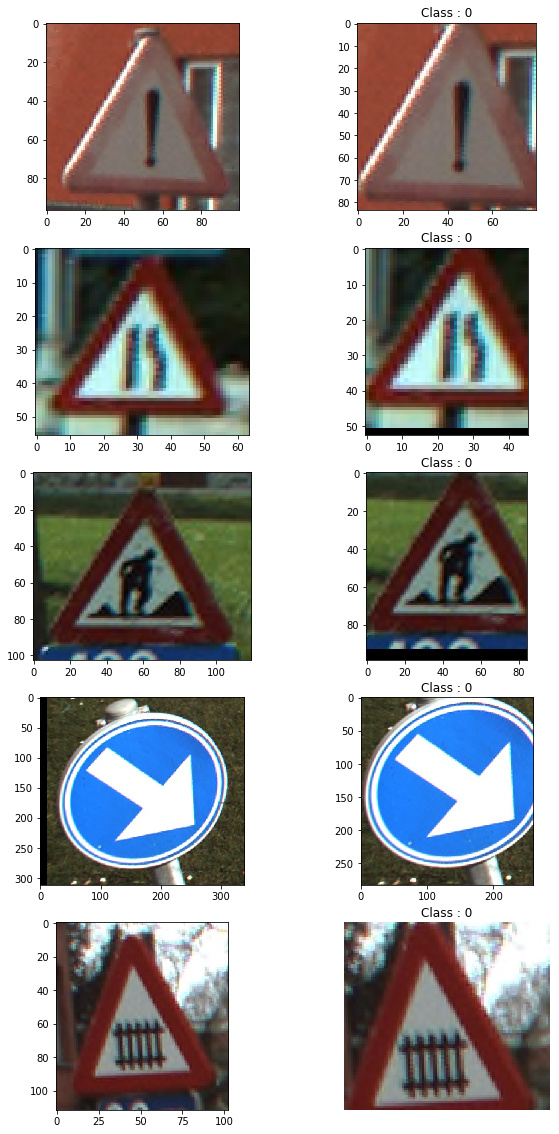

In [30]:
showTestExamples(df_test)

In [31]:
X = df_test.drop(Y_col_name, axis=1)
y = df_test[Y_col_name]
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Fit and apply the oversampler to the data
X_resampled, y_resampled = oversampler.fit_resample(X, y)

df_test = pd.DataFrame(X_resampled, columns=X.columns)
df_test[Y_col_name] = y_resampled
df_test[Y_col_name] = df_test[Y_col_name].astype(str)

In [32]:
df_test.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,Rotate,length,height,ClassId
0,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,108.0,106.0,9.0,9.0,99.0,97.0,0,90.0,88.0,30.0
1,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,52.0,53.0,5.0,5.0,46.0,47.0,0,41.0,42.0,30.0
2,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,70.0,68.0,6.0,6.0,63.0,62.0,0,57.0,56.0,30.0
3,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,75.0,67.0,6.0,6.0,68.0,61.0,0,62.0,55.0,30.0
4,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,74.0,73.0,6.0,6.0,67.0,67.0,0,61.0,61.0,30.0


In [33]:
test_images = []
data = Data(df_test,resize_x,resize_y)
data.Get_Data()
X_test  = data.X
y_test = data.Y


In [34]:
pred = model.predict(X_test)
y_pred = np.argmax(pred, axis=1)
print(y_pred)
print(y_test)

[28 28 28 ... 28 28  6]
[30 30 30 ... 61 61 61]


In [35]:
confusion = confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = np.sum(np.diag(confusion)) / np.sum(confusion)
print("Total Accuracy: ", accuracy*100)


# Calculate precision, recall, and F1-score
classification_rep = classification_report(y_test, y_pred, labels=np.unique(y_pred))

# Print the results
print("\nConfusion Matrix:\n", confusion)


lines = classification_rep.split('\n')
data = []

for line in lines[2:-5]:  # Exclude header and footer lines
    row_data = line.split()
    if len(row_data) > 0:
        class_name = row_data[0]
        precision = float(row_data[1])
        recall = float(row_data[2])
        f1_score = float(row_data[3])
        support = int(row_data[4])
        data.append([class_name, precision, recall, f1_score, support])

# Create a DataFrame
report = pd.DataFrame(data, columns=['Class', 'Precision', 'Recall', 'F1-Score', 'Support'])
# Print the DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print("\n\n\n Summarizing the results : ")
report

Total Accuracy:  1.8623655913978494

Confusion Matrix:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]



 Summarizing the results : 


,Class,Precision,Recall,F1-Score,Support
0,6,0.22,0.30,0.25,375
1,9,0.00,0.01,0.00,375
2,14,0.00,0.00,0.00,375
3,19,0.00,0.00,0.00,375
4,26,0.30,0.14,0.19,375
5,27,0.00,0.00,0.00,375
6,28,0.01,0.50,0.02,375
7,31,0.00,0.00,0.00,375
8,32,0.04,0.19,0.07,375
9,33,0.02,0.01,0.01,375


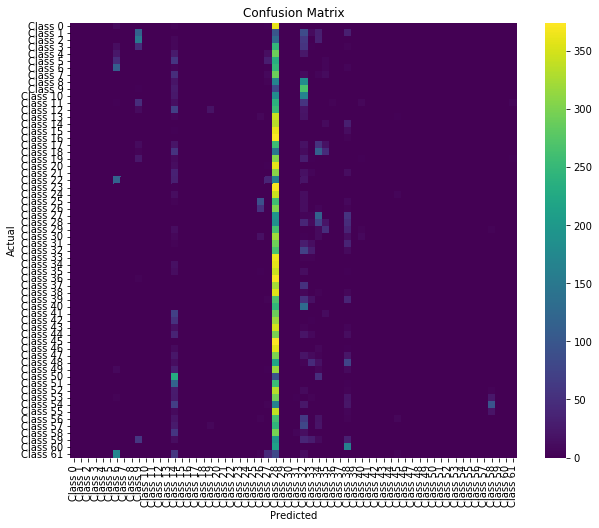

In [36]:
class_names = []
for i in range(num_of_classes):
    class_names.append("Class "+str(i))
# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=False, cmap="viridis", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()